<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Deep Learning in Finance MAP548 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Project 1 -  Deep pricing and calibration </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>



- MANSARD Diane
- POTTIER Clément

<font color='red'>**DEADLINE: March 2 (5:00 pm)**</font>

<font color='red'>**PLease send both pdf ipynb files with name : Name1_Name2_Project1**</font>

# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

# Your task

Inspired by the deep pricer for the one factor Bergomi model. Implement a deep pricer for the two factor Bergomi model. You have to generate your own training set using a scheme of your choice that you have to detail (use the fixed grid for strikes and maturities below).

Once your NN is trained, showcase the train and test error, and perform a calibration on the market implied volatility surface that was used in the one factor Bergomi and comment. 

Also provide/display the output prices of the NN of the set of parameters set 1, 2 and 3 below. 

You have to provide a notebook that compiles, together with the trained weights of your Neural Networks that we can load with the command: *model_iv.load_weights('2FBergomiNNWeights.h5')*. 

(!) The actual training of NN is not difficult, the difficult part is to get good data (and lots of it), so be careful about your simulation schemes (training might require a larger dataset than for 1 factor bergomi).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Dropout, Flatten, Input
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow import keras
from sklearn.model_selection import train_test_split

## Let's start simulating Xt1 and Xt2 using a recursive method

##### [We first study how to simulate one price, to then implement at a larger scale.]

Define the process for a 1-factor model:

$$
\widetilde X_t = e^{\kappa t}X_t = \int_0^t e^{\kappa s} dW_s,
$$

so that

$$
\widetilde X_{t_{j+1}} = \widetilde X_{t_j} + \int_{t_{j}}^{t_{j+1}}e^{\kappa s} dW_s =  \
    \widetilde X_{t_j}+\sqrt{\frac{e^{2 \kappa t_{j+1}}-e^{2 \kappa t_{j}}}{2\kappa}}Y_j,
$$

with $t_0 = 0, \quad t_N = T, \quad Y_i  \sim \mathcal{N}(0, 1)$ iid. Thus we first simulate $\widetilde X_{t_{j+1}}$ and then convert back to $X_t$ by:

$$
 X_t = e^{-\kappa t} \widetilde X_t.
$$

We then finally multiply by the corresponding eta to get the final value of the process for each Xt.

## A step-by-step Bergomi model implementation

Let's first create a ste-by-step model to ensure that the model is working as expected.

In [2]:
xi, kappa_1, eta_1, eta_2, rho, = 0.14, 35, 20, 3, -0.5
kappa_2 = 2.6
T = 2
n_steps = 1000 # number of time steps
N_sims = 50 # number of simulations for Monte Carlo 

dt = T/n_steps
tt = np.linspace(0., T, n_steps + 1)

Define the time variables

In [3]:
times_to_find = [0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ] # list of the value to search for

indices = {time: np.argmin(np.abs(tt - time)) for time in times_to_find} # si approx numérique prend le plus proche, mieux pour stocker les indices: 

for time, index in indices.items():
    print(f"Time interval of {time}:", f"index {index} of the matrix tt")

Time interval of 0.1: index 50 of the matrix tt
Time interval of 0.3: index 150 of the matrix tt
Time interval of 0.6: index 300 of the matrix tt
Time interval of 0.9: index 450 of the matrix tt
Time interval of 1.2: index 600 of the matrix tt
Time interval of 1.5: index 750 of the matrix tt
Time interval of 1.8: index 900 of the matrix tt
Time interval of 2.0: index 1000 of the matrix tt


Generate the Brownian motion path

In [4]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

w1 = gen_bm_path(n_steps,N_sims)

Simulation of Xt1

In [5]:
exp1_Xt1 = np.exp(kappa_1*tt[1:])
exp2_Xt1 = np.exp(2*kappa_1*tt)

diff_exp2_Xt1 = np.diff(exp2_Xt1)
std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt1 = exp1_Xt1[:,np.newaxis]
Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
Xt1 = eta_1*Xt1

Simulation of Xt2

In [6]:
exp1_Xt2 = np.exp(kappa_2*tt[1:])
exp2_Xt2 = np.exp(2*kappa_2*tt)

diff_exp2_Xt2 = np.diff(exp2_Xt2)
std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt2 = exp1_Xt2[:,np.newaxis]
Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
Xt2 = eta_2*Xt2

Creation of Xt

In [7]:
Xt = Xt1 + Xt2

Let's plot the different brownian motions:

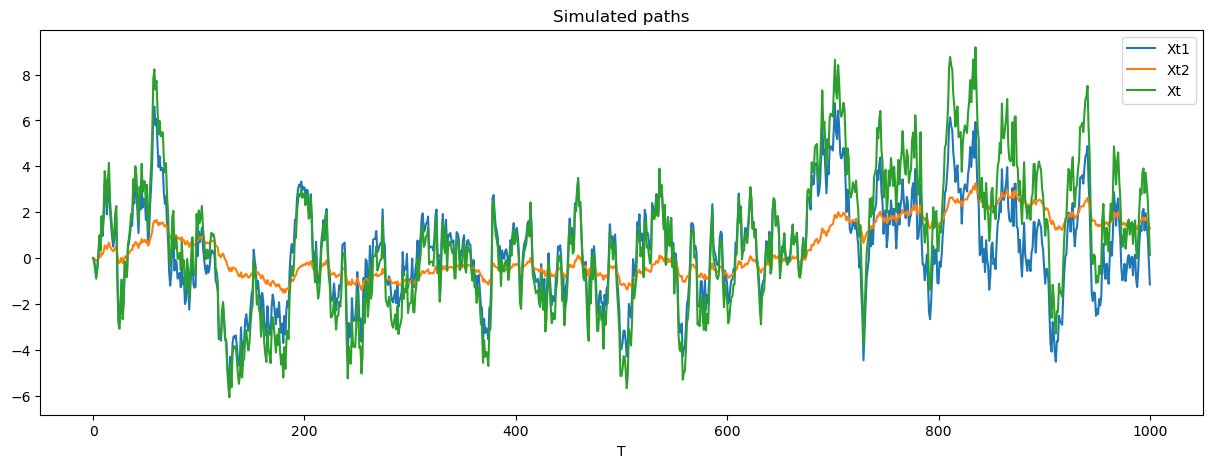

In [8]:
i_ind = 1
plt.figure(figsize=(15,5))
plt.plot(Xt1[:,i_ind],label='Xt1')
plt.plot(Xt2[:,i_ind],label='Xt2')
plt.plot(Xt[:,i_ind],label='Xt')
plt.xlabel('T')
plt.title('Simulated paths')
plt.legend()
plt.show()

## Simulation of Vt and St with fixed parameters

The variance is computed as follow, we use the properties of the ItÔ intergrals :

$
\mathbb{V}[X_t] = \mathbb{V}[X_t^1] + \mathbb{V}[X_t^2] + 2 \mathbb{COV}[X_t^1, X_t^2]
$

$
\mathbb{V}[X_t] = \eta_1 \int_0^t e^{-\kappa_1 (t-s)} dW_s + \eta_2 \int_0^t e^{-\kappa_2 (t-s)} dW_s + 2\eta_1 \eta_2 \int_0^t e^{-\kappa_1 (t-s)} e^{-\kappa_2 (t-s)} ds
$

$
\mathbb{V}[X_t] = \eta_1^2 \frac{1 - e^{-2\kappa_1 t}}{2\kappa_1} + \eta_2^2 \frac{1 - e^{-2 \kappa_2 t}}{2 \kappa_2} + \eta_1 \eta_2 e^{-t(\kappa_1 + \kappa_2)}\int_0^t e^{(\kappa_1 + \kappa_2)s} ds
$

$
\mathbb{V}[X_t] = \eta_1^2 \frac{1 - e^{-2\kappa_1 t}}{2\kappa_1} + \eta_2^2 \frac{1 - e^{-2\kappa_2 t}}{2\kappa_2} + \eta_1 \eta_2 \frac{1 - e^{-t(\kappa_1 + \kappa_2)}}{\kappa_1 + \kappa_2}
$


In [9]:
var1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
var2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
covar = eta_1*eta_2*(1-np.exp(-(kappa_1+kappa_2)*tt))/(kappa_1+kappa_2) 
var = var1 + var2 + 2*covar

Vt = xi * np.exp(Xt - 0.5 * var[:, np.newaxis]) #variance calculated for each time step 

Let's initialize 2 brownian paths and calculate the corresponding S values

In [10]:
w1 = gen_bm_path(n_steps,N_sims)
w2 = gen_bm_path(n_steps,N_sims)

In [11]:
S0 = 100
r = 0.02 

log_S = np.ones(N_sims).reshape(1,-1)*np.log(S0)
epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
for j in epochs_iter_j:
    log_S_next = log_S[j]-0.5*Vt[j]*dt+np.sqrt(Vt[j]*dt)*\
        (rho*w1[j]+np.sqrt(1-rho**2)*w2[j]) 
    log_S=np.append(log_S,log_S_next.reshape(1,-1),axis=0)

S = np.exp(log_S)

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

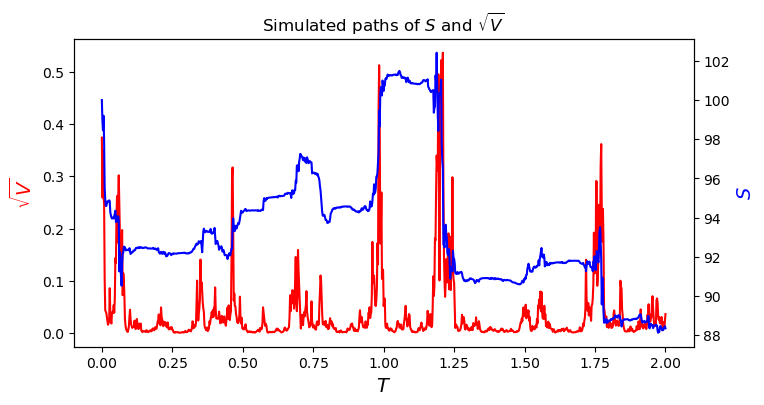

In [12]:
i_ind = 4 # The 4-th simulation
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax2 = ax.twinx()
lns2 = ax2.plot(tt,np.array(S[:,i_ind]), '-b',label = r'$S$')
lns1 = ax.plot(tt,np.sqrt(Vt[:,i_ind]), 'r',ls='-', label = r'$\sqrt{V}$')
labs = [l.get_label() for l in lns2+lns1]
ax.set_xlabel(r"$T$",size=14)
ax.set_ylabel(r'$\sqrt{V}$', color='red',size=14)
ax2.set_ylabel(r'$S$', color='blue',size=14)
plt.title(r'Simulated paths of $S$ and $\sqrt{V}$')
plt.show()

Let's now compute the prices of the option with the Monte Carlo method

With K=100 and T=2, the option price is:

In [13]:
K = 100

# Do the average of the payoffs of all the simulations
price = np.exp(-r*T) * np.mean(np.maximum(S[-1] - K, 0)) 
print(f"The option payoff is {price:.2f}")

The option payoff is 10.02


With K=100 and the requested time intervals:

In [14]:
for time, index in indices.items():
    price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - K, 0))
    print(f"The option payoff at time {time} is {price:.2f}")

The option payoff at time 0.1 is 3.10
The option payoff at time 0.3 is 3.69
The option payoff at time 0.6 is 4.18
The option payoff at time 0.9 is 9.00
The option payoff at time 1.2 is 8.06
The option payoff at time 1.5 is 7.75
The option payoff at time 1.8 is 9.03
The option payoff at time 2.0 is 10.42


Option prices at different strikes:

In [15]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*S0

Let's plot the results for the different strikes:

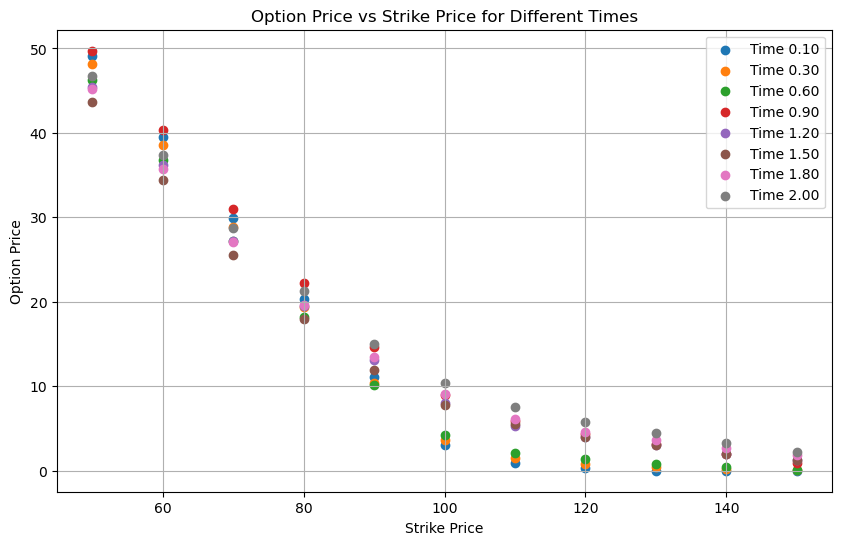

In [16]:
prices = {}

for time, index in indices.items():
    prices[time] = []
    for strike in strikes:
        price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0))
        prices[time].append((strike, price))

# Plot the results
plt.figure(figsize=(10, 6))
for time, prices_data in prices.items():
    strikes, prices_values = zip(*prices_data)
    plt.scatter(strikes, prices_values, label=f'Time {time:.2f}')

plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Option Price vs Strike Price for Different Times')
plt.legend()
plt.grid(True)
plt.show()

The option price decreases when the strike price increases, which is an encouraging sign that our simulation makes sense. 

Let's implement the result in an array 

In [17]:
parameters = [xi, kappa_1, eta_1, eta_2, rho]
x = np.array(parameters).reshape(1, -1) 
x.shape

(1, 5)

In [18]:
values_list = [value for sublist in prices.values() for value in sublist]
y = np.array(values_list)

y.shape 

(88, 2)

In [19]:
print(y)

[[5.00000000e+01 4.91631750e+01]
 [6.00000000e+01 3.95360456e+01]
 [7.00000000e+01 2.99089162e+01]
 [8.00000000e+01 2.03699709e+01]
 [9.00000000e+01 1.11279266e+01]
 [1.00000000e+02 3.09676409e+00]
 [1.10000000e+02 8.85718009e-01]
 [1.20000000e+02 3.27074101e-01]
 [1.30000000e+02 0.00000000e+00]
 [1.40000000e+02 0.00000000e+00]
 [1.50000000e+02 0.00000000e+00]
 [5.00000000e+01 4.82114428e+01]
 [6.00000000e+01 3.85457277e+01]
 [7.00000000e+01 2.88800127e+01]
 [8.00000000e+01 1.93956460e+01]
 [9.00000000e+01 1.03853263e+01]
 [1.00000000e+02 3.68955514e+00]
 [1.10000000e+02 1.46758927e+00]
 [1.20000000e+02 8.53060819e-01]
 [1.30000000e+02 4.66432217e-01]
 [1.40000000e+02 2.34093623e-01]
 [1.50000000e+02 4.07793219e-02]
 [5.00000000e+01 4.62878906e+01]
 [6.00000000e+01 3.67584846e+01]
 [7.00000000e+01 2.72350101e+01]
 [8.00000000e+01 1.82231492e+01]
 [9.00000000e+01 1.01787366e+01]
 [1.00000000e+02 4.17909554e+00]
 [1.10000000e+02 2.07830667e+00]
 [1.20000000e+02 1.42843007e+00]
 [1.300000

It seems that our model is correct. Let's now implement it in a more efficient way to generate our datatrain

# Creation of the datatrain

- After different combinations of number of simulation vs. number of training data we noticed that having a significative number of simulation is more important to improve the quality of the model. 
- Even if the number of training data simulated is non negligeable, we created a datatrain of size 20k in a respectable amount of time with our computational power (it required 9h to created this one, and it would be complicated to create on a larger datatrain, even if it would have improved the results)

Let's create a datatrain of 20k samples using a Monte-Carlo method over 2k simulations.

In [20]:
N=20000
N_sims = 2000
kappa_2 = 2.
T = 2
n_steps = 1000
dt = T / n_steps
S0 = 100
tt = np.linspace(0, T, n_steps + 1)
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])*S0
indices = {time: np.argmin(np.abs(tt - time)) for time in [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0]}
r = 0.02

In [21]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

Simulation of the data

In [44]:
X_data = np.array([]).reshape(0, 5)
y_data = np.array([]).reshape(0, 88)

for i in tqdm(range(N), desc="Avancement", unit="iter"):
    xi = np.random.uniform(0.03, 0.25)
    kappa_1 = np.random.uniform(10, 60)
    eta_1 = np.random.uniform(5, 35)
    eta_2 = np.random.uniform(1, 5)
    rho = np.random.uniform(-0.9, -0.1)
    
    
    w1 = gen_bm_path(n_steps, N_sims)
    w2 = gen_bm_path(n_steps, N_sims)
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    # sim Xt1
    exp1_Xt1 = np.exp(kappa_1*tt[1:])
    exp2_Xt1 = np.exp(2*kappa_1*tt)

    diff_exp2_Xt1 = np.diff(exp2_Xt1)
    std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt1 = exp1_Xt1[:,np.newaxis]
    Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
    Xt1 = eta_1*Xt1
    
    # sim Xt2

    #w_corr = rho * w1 + np.sqrt(1 - rho**2) * w2

    exp1_Xt2 = np.exp(kappa_2*tt[1:])
    exp2_Xt2 = np.exp(2*kappa_2*tt)

    diff_exp2_Xt2 = np.diff(exp2_Xt2)
    std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt2 = exp1_Xt2[:,np.newaxis]
    Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
    Xt2 = eta_2*Xt2
    
    Xt = Xt1 + Xt2
    
    #calcul de Vt
    var1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
    var2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
    covar = eta_1*eta_2*(1-np.exp(-(kappa_1+kappa_2)*tt))/(kappa_1+kappa_2) 
    var = var1 + var2 + 2*covar

    Vt = xi * np.exp(Xt - 0.5 * var[:, np.newaxis])
    
    # discounted!! prices
    for j in range(n_steps):
        log_S_next = log_S[j] - 0.5 * Vt[j] * dt + np.sqrt(Vt[j] * dt) * (rho * w1[j] + np.sqrt(1 - rho**2) * w2[j])
        log_S = np.append(log_S, log_S_next.reshape(1,-1), axis=0)
    
    S = np.exp(log_S)
    prices = {}
    
    for time, index in indices.items():
        prices[time] = []
        for strike in strikes:
            price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0))
            prices[time].append(price)

    values_list = [value for sublist in prices.values() for value in sublist]
    y = np.array(values_list)
    X = np.array([xi, kappa_1, eta_1, eta_2, rho]).reshape(1, -1)
    X_data = np.append(X_data, X, axis=0)
    y_data = np.append(y_data, y.reshape(1, -1), axis=0)
    pourcentage = (i + 1) / N * 100
    print(f"\rProgression : {pourcentage:.2f}%", end="", flush=True)
    

Avancement:   0%|          | 0/20000 [00:00<?, ?iter/s]

Progression : 100.00%

Let's check the shape of the data obtained

In [45]:
print(X_data.shape, y_data.shape)

(20000, 5) (20000, 88)


In [46]:
print("Stats des features X:")
print(pd.DataFrame(X_data).describe())

print("\nStats des labels y:")
print(pd.DataFrame(y_data).describe())


Stats des features X:
                  0             1             2             3             4
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.139733     35.060984     19.950709      2.998564     -0.501921
std        0.063380     14.458089      8.676348      1.151190      0.230896
min        0.030010     10.003982      5.000009      1.000352     -0.899971
25%        0.084909     22.435661     12.371490      2.005818     -0.702494
50%        0.139813     35.190658     19.943424      2.994380     -0.503171
75%        0.194309     47.558675     27.508005      3.998557     -0.301550
max        0.249995     59.999244     34.998204      4.999947     -0.100069

Stats des labels y:
                 0             1             2             3             4   \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      48.187078     38.602317     29.057022     19.605852     10.427082   
std        0.202210      0.204453   

Let's plot the distribution of the data obtained:

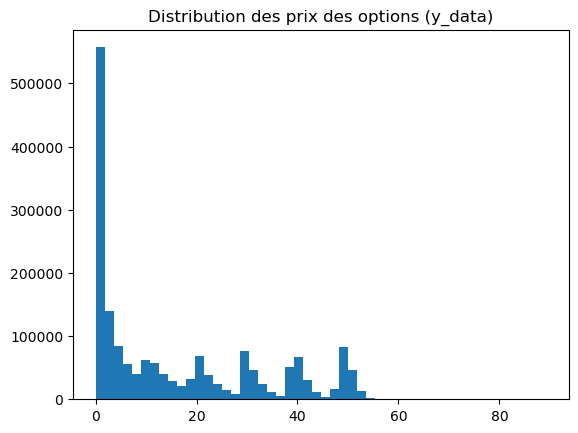

In [ ]:
plt.hist(y_data.flatten(), bins=50)
plt.title("Distribution des prix des options (y_data)")
plt.show()

The Gaussian characteristics of the data is visible even if difficult to perfectly affirm. Indeed, due to the nature of the data and the use of the max function for different strike prices, the shape of the plot is not surprizing and quite satisfying

Let's save our training set in a CSV file to be able to load it later.

In [48]:
df_train = pd.DataFrame(X_data, columns=['xi', 'kappa_1', 'eta_1', 'eta_2', 'rho'])
df_train = pd.concat([df_train, pd.DataFrame(y_data)], axis=1)

df_train.to_csv('training_set_N20K_Nsim2000.csv', index=False)

The creation of the training data set is done. We spent quite a lot of time on this part, trying to optimize the number of siumalations and the number samples genrated to have the best basis to train our algorithm. This appeared to be the best compromise quality of the data/ time to generate it (9h in this case). With more computational power, we could have generated more samples and more simulations to have a better training set.

## Preparation of the training data

Let's separate our inputs from our outputs:

In [22]:
training_data = pd.read_csv('training_set_N20K_Nsim2000.csv')
training_data = training_data.to_numpy()
X_data = training_data[:,:5]
y_data = training_data[:,5:]
X = X_data
target_y = np.log1p(y_data)

print(training_data.shape)
print('X shape:', X.shape)
print('Y shape:', target_y.shape)

(20000, 93)
X shape: (20000, 5)
Y shape: (20000, 88)


Split the Data between training (85%) and testing (15%). 

In [23]:
X_indexed = np.concatenate((np.arange(X.shape[0])[np.newaxis].T,X),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, target_y, test_size=0.15, random_state=42)

train_index = X_train[:,0].astype(int)
test_index = X_test[:,0].astype(int)
X_train = X_train[:,1:]
X_test = X_test[:,1:]

Normalise inputs between $[-1,1]$

In [24]:
def input_norm_transform(x, x_min, x_max, norm_min, norm_max):
    return (x-x_min)/(x_max-x_min)*(norm_max-norm_min)+norm_min
def input_norm_transform_inv(x_norm, x_min, x_max, norm_min, norm_max):
    return (x_norm-norm_min)/(norm_max-norm_min)*(x_max-x_min)+x_min

x_max = np.array([np.max(X_train[:,0]),  np.max(X_train[:,1]),  np.max(X_train[:,2]), np.max(X_train[:,3]), np.max(X_train[:,4])])
x_min = np.array([np.min(X_train[:,0]),  np.min(X_train[:,1]),  np.min(X_train[:,2]), np.min(X_train[:,3]), np.min(X_train[:,4])])
x_norm_min = -1
x_norm_max = 1

x_train_transform = input_norm_transform(X_train, x_min, x_max, x_norm_min, x_norm_max)
x_test_transform = input_norm_transform(X_test, x_min, x_max, x_norm_min, x_norm_max)

Let's check the range of the input simulated for each parameter:

In [25]:
print('x_max:', x_max)
print('x_min:', x_min)

x_max: [ 0.24999495 59.99924387 34.99820427  4.99994668 -0.10006883]
x_min: [ 0.0300098  10.01465169  5.0000092   1.00035185 -0.8999707 ]


We recover here the grid for the parameters of the model.

In [26]:
#Standardising output data y to the interval, so it is centred with variance 1
def output_norm_transform(y, mean, std):
    return (y-mean)/std
def output_norm_transform_inv(y_trans, mean, std):
    return y_trans*std+mean

y_mean = np.average(y_train,axis=0)
y_std = np.std(y_train,axis=0)

y_train_transform = output_norm_transform(y_train, y_mean, y_std)
y_test_transform = output_norm_transform(y_test, y_mean, y_std)

Check that the values of the dataset have been well preprocessed :

In [27]:
print("Min X_train after normalisation:", x_train_transform.min())
print("Max X_train after normalisation:", x_train_transform.max())
print("Mean y_train_transform:", y_train_transform.mean())
print("Std y_train_transform:", y_train_transform.std())

Min X_train after normalisation: -1.0
Max X_train after normalisation: 1.0
Mean y_train_transform: -4.410205771580848e-14
Std y_train_transform: 1.0000000000000004


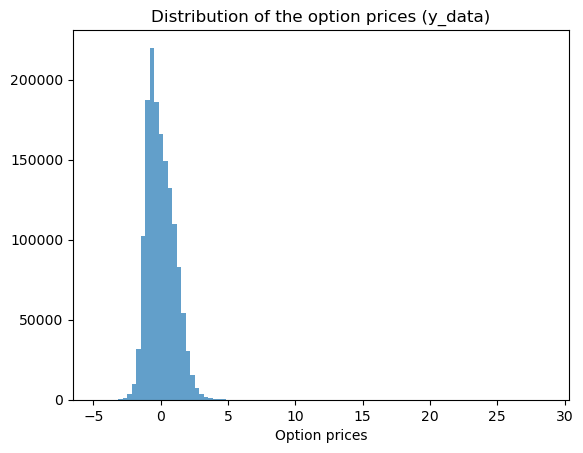

In [28]:
plt.hist(y_train_transform.flatten(), bins=100, alpha=0.7, label='y_train_transform')
plt.title("Distribution of the option prices (y_data)")
plt.xlabel('Option prices')
plt.show()

## Building a Convolutionnal Neural Network

After different tests using various algorithms, CNN appears to be the more promising model.

In [29]:
num_strikes = 11 
num_maturities = 8
output_shape = (num_strikes, num_maturities, 1)

In order to avoid overfiiting, we will use a dropout layer with a dropout rate of 0.25. We will also use a batch normalization layer to speed up the training process 

In [30]:
model_cnn_tuned = Sequential([
    Input(shape=(5,)),  # Use Input layer as the first layer
    Dense(128, activation="elu"),
    Dense(num_strikes * num_maturities, activation="elu"),
    Reshape(output_shape),

    Conv2D(32, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Dropout(0.25),  # Adding dropout for regularization

    Conv2D(64, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Dropout(0.25),  # Adding dropout for regularization

    Conv2D(128, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation="elu", padding="same"),
    BatchNormalization(),
    Dropout(0.25),  # Adding dropout for regularization

    Conv2D(1, kernel_size=(3, 3), activation="linear", padding="same"),  # Single output per pixel
    Flatten()  # Flatten to vector form (88 option prices)
])

model_cnn_tuned.compile(optimizer="adam", loss="mse")

model_cnn_tuned.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 88)             │        11,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 11, 8, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 11, 8, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 8, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 8, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 8, 1)       │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 88)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,497 (1.15 MB)

 Trainable params: 300,601 (1.15 MB)

 Non-trainable params: 896 (3.50 KB)

Let's now train the model over 50 epochs using a batch size of 64:

In [34]:
# Enable debug mode for tf.data functions
tf.data.experimental.enable_debug_mode()

# Your training code
train_hist_cnn_tuned = model_cnn_tuned.fit(
    x_train_transform, y_train_transform, 
    batch_size=64, epochs=50, 
    validation_data=(x_test_transform, y_test_transform)
)

Epoch 1/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 181ms/step - loss: 0.4763 - val_loss: 0.8050
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - loss: 0.2313 - val_loss: 0.3880
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - loss: 0.2184 - val_loss: 0.2189
Epoch 4/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - loss: 0.2274 - val_loss: 0.2570
Epoch 5/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 167ms/step - loss: 0.2079 - val_loss: 0.2480
Epoch 6/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - loss: 0.2132 - val_loss: 0.2082
Epoch 7/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - loss: 0.2039 - val_loss: 0.2012
Epoch 8/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - loss: 0.1963 - val_loss: 0.2235
Epoch 9/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - loss: 0.2023 - val_loss: 0.1989
Epoch 10/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 167ms/step - loss: 0.1996 - val_loss: 0.2054
Epoch 11/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - loss: 0.1950 - val_loss: 0.2012
Epoch 12/50
266/266

Let's plot the evolution of the loss function during the training process:

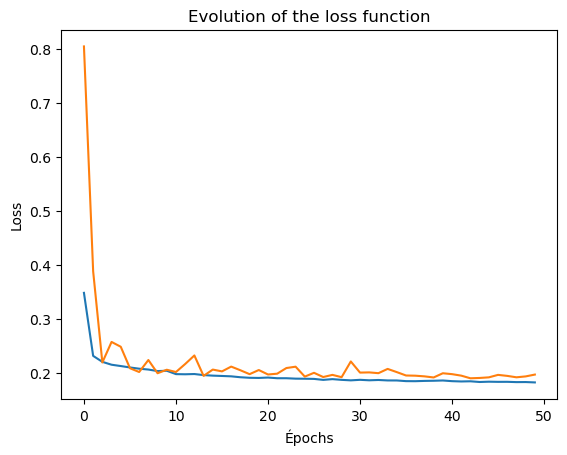

In [35]:
plt.plot(train_hist_cnn_tuned.history['loss'])
plt.plot(train_hist_cnn_tuned.history['val_loss'])
plt.title("Evolution of the loss function")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
test_loss_cnn_tuned = model_cnn_tuned.evaluate(x_test_transform, y_test_transform)
print(f"Test Loss: {test_loss_cnn_tuned}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1940
Test Loss: 0.19646237790584564


Let's save the weights of the model.

In [31]:
model_cnn_tuned.save_weights('2FBergomiNNWeights_final_batch64.weights.h5')

### Predictions for an existing grid of paramters (used for training):

We are expecting the model to do well as he learnt from those parameters. We also make this plot to be sure that our results are coherent. 

In [32]:
warnings.filterwarnings('ignore')
model_cnn_tuned.load_weights('2FBergomiNNWeights_final_batch64.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


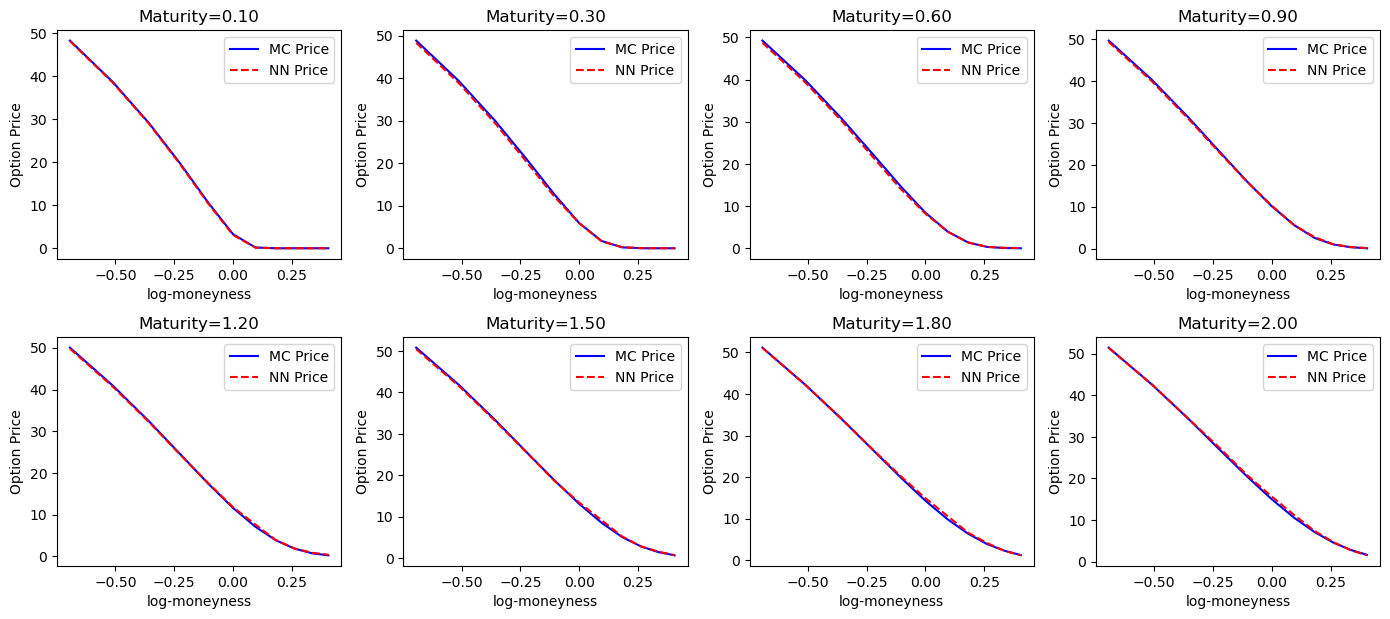

In [ ]:
sample_ind = 100
X_input = X_test[sample_ind]
X_input_transform = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

strikes_dim = len(strikes)
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])
maturities_dim = len(maturities)

strikes = np.array(strikes)
S0 = np.array(S0)

y_true = np.exp(y_test[sample_ind])-1
y_pred = np.exp(output_norm_transform_inv(model_cnn_tuned.predict(X_input_transform.reshape(1, -1)), y_mean, y_std))-1


plt.figure(figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), y_true[i * strikes_dim:(i + 1) * strikes_dim], 'b', label="MC Price")

    plt.plot(np.log(strikes / S0), y_pred[0, i * strikes_dim:(i + 1) * strikes_dim], '--r', label="NN Price")

    plt.title(f"Maturity={maturities[i]:.2f}")
    plt.xlabel("log-moneyness")
    plt.ylabel("Option Price")
    plt.legend()

plt.tight_layout()
plt.show()

## Final predictions

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

In [41]:
xi = 0.06
kappa = 41.6
eta_1 = 18.2428
eta_2 = 3.43
rho = -0.7

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_cnn_tuned.predict(X_input_norm)

y_pred = output_norm_transform_inv(y_pred_norm, y_mean, y_std)
y_pred_1 = np.exp(y_pred)-1

print("Predicted option prices for parameter set 1:", y_pred_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted option prices for parameter set 1: [[ 4.81492091e+01  3.85423823e+01  2.89614795e+01  1.94418970e+01
   1.00815573e+01  1.70966305e+00  2.43814670e-02  4.27897708e-03
   5.91567908e-03  8.77075037e-04 -2.41170794e-03  4.84254636e+01
   3.88624168e+01  2.93358850e+01  1.99426933e+01  1.08389923e+01
   3.01454064e+00  2.87122899e-01  6.96884857e-02  2.89547055e-02
   1.66574593e-02  9.19577856e-03  4.88672998e+01  3.93108112e+01
   2.98910516e+01  2.06533870e+01  1.17762002e+01  4.25927727e+00
   6.97753132e-01  1.80652691e-01  7.96851870e-02  4.02620336e-02
   4.10997462e-02  4.92820152e+01  3.97447577e+01  3.04153873e+01
   2.12948544e+01  1.26555688e+01  5.23349088e+00  1.23267330e+00
   4.46337619e-01  1.78866930e-01  6.84538354e-02  4.00364191e-02
   4.96878035e+01  4.02009513e+01  3.08654715e+01  2.18687627e+01
   1.35186762e+01  6.30922545e+00  1.88254789e+00  6.55947765e-01
   2.86894260e-01  1.62802546e-01  7.57995850e-02  5.014320

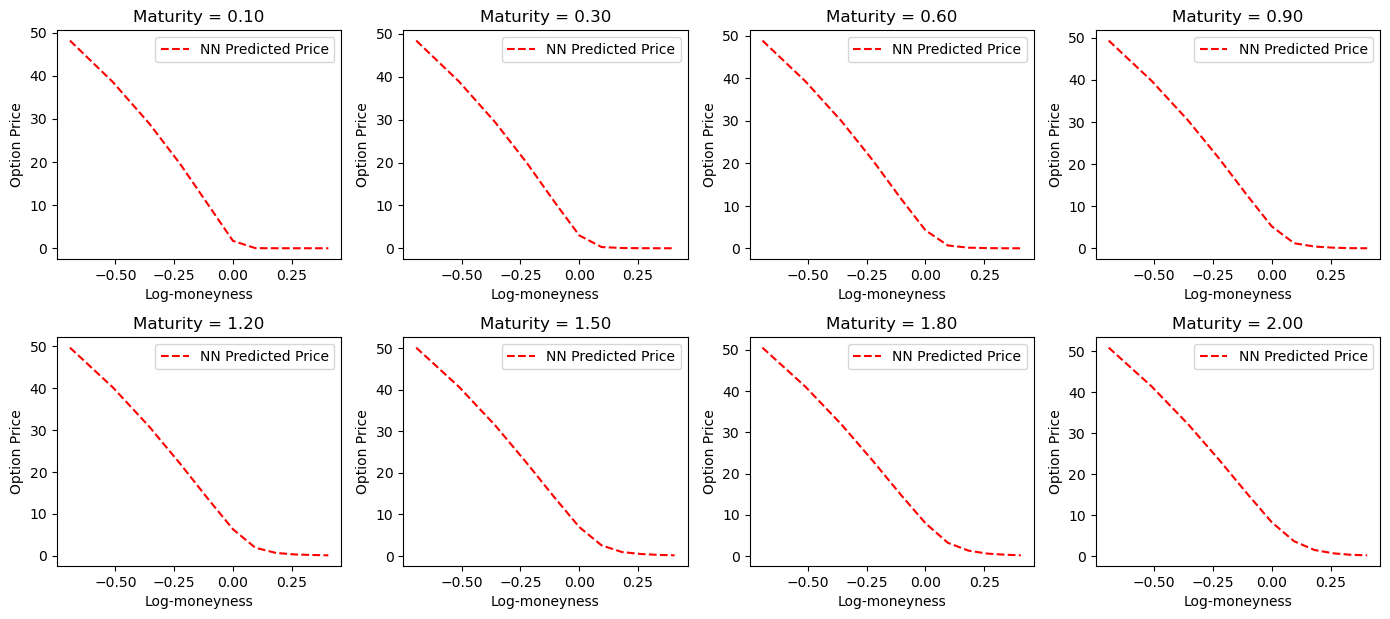

In [42]:
plt.figure(figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), y_pred_1[0, i * strikes_dim:(i + 1) * strikes_dim], 'r', linestyle="--", label="NN Predicted Price")

    plt.title(f"Maturity = {maturities[i]:.2f}")
    plt.xlabel("Log-moneyness")
    plt.ylabel("Option Price")
    plt.legend()

plt.tight_layout()
plt.show()

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

In [43]:
xi = 0.1
kappa = 15.6
eta_1 = 5.5857
eta_2 = 2.2867
rho = -0.4

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_cnn_tuned.predict(X_input_norm)

y_pred_2log = output_norm_transform_inv(y_pred_norm, y_mean, y_std)
y_pred_2 = np.exp(y_pred)-1

print("Predicted option prices for parameter set 2:", y_pred_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted option prices for parameter set 2: [[ 4.81492091e+01  3.85423823e+01  2.89614795e+01  1.94418970e+01
   1.00815573e+01  1.70966305e+00  2.43814670e-02  4.27897708e-03
   5.91567908e-03  8.77075037e-04 -2.41170794e-03  4.84254636e+01
   3.88624168e+01  2.93358850e+01  1.99426933e+01  1.08389923e+01
   3.01454064e+00  2.87122899e-01  6.96884857e-02  2.89547055e-02
   1.66574593e-02  9.19577856e-03  4.88672998e+01  3.93108112e+01
   2.98910516e+01  2.06533870e+01  1.17762002e+01  4.25927727e+00
   6.97753132e-01  1.80652691e-01  7.96851870e-02  4.02620336e-02
   4.10997462e-02  4.92820152e+01  3.97447577e+01  3.04153873e+01
   2.12948544e+01  1.26555688e+01  5.23349088e+00  1.23267330e+00
   4.46337619e-01  1.78866930e-01  6.84538354e-02  4.00364191e-02
   4.96878035e+01  4.02009513e+01  3.08654715e+01  2.18687627e+01
   1.35186762e+01  6.30922545e+00  1.88254789e+00  6.55947765e-01
   2.86894260e-01  1.62802546e-01  7.57995850e-02  5.014320

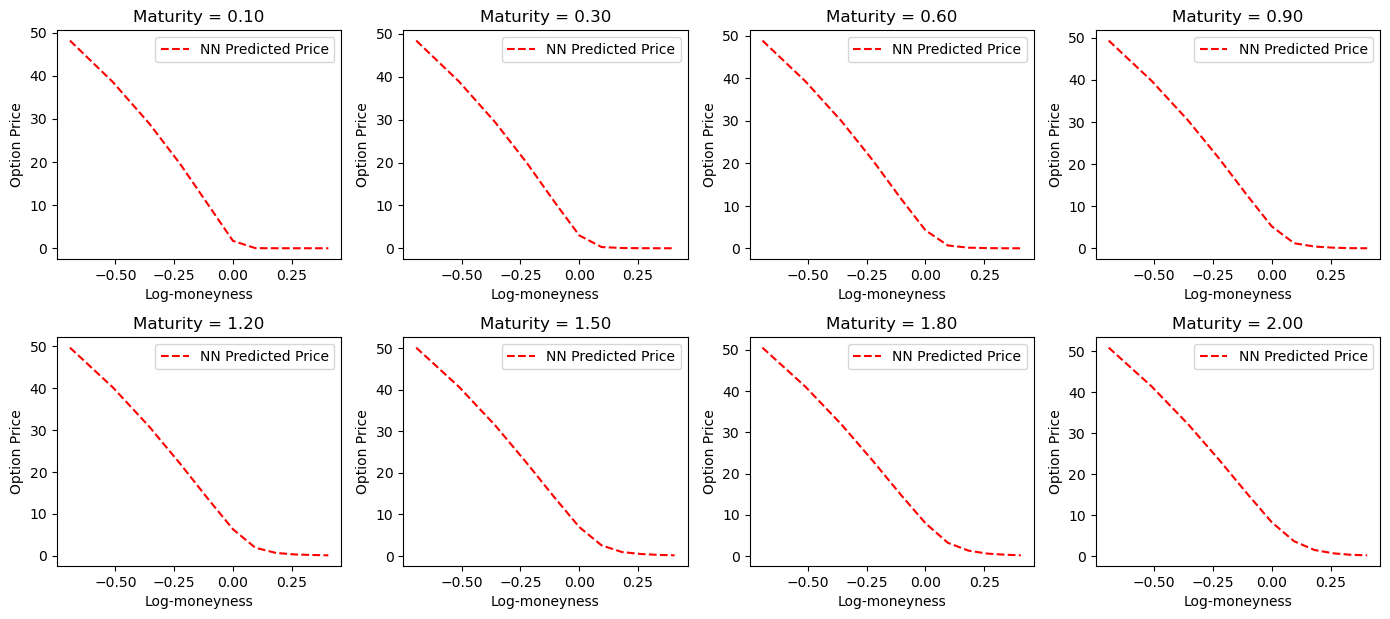

In [44]:
plt.figure(figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), y_pred_2[0, i * strikes_dim:(i + 1) * strikes_dim], 'r', linestyle="--", label="NN Predicted Price")

    plt.title(f"Maturity = {maturities[i]:.2f}")
    plt.xlabel("Log-moneyness")
    plt.ylabel("Option Price")
    plt.legend()

plt.tight_layout()
plt.show()

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

In [45]:
xi = 0.2
kappa = 54.6
eta_1 = 31.3496
eta_2 = 4.5733
rho = -0.8

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_cnn_tuned.predict(X_input_norm)

y_pred = output_norm_transform_inv(y_pred_norm, y_mean, y_std)
y_pred_3 = np.exp(y_pred)-1

print("Predicted option prices for parameter set 3:", y_pred_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted option prices for parameter set 3: [[ 4.81492091e+01  3.85423823e+01  2.89614795e+01  1.94418970e+01
   1.00815573e+01  1.70966305e+00  2.43814670e-02  4.27897708e-03
   5.91567908e-03  8.77075037e-04 -2.41170794e-03  4.84254636e+01
   3.88624168e+01  2.93358850e+01  1.99426933e+01  1.08389923e+01
   3.01454064e+00  2.87122899e-01  6.96884857e-02  2.89547055e-02
   1.66574593e-02  9.19577856e-03  4.88672998e+01  3.93108112e+01
   2.98910516e+01  2.06533870e+01  1.17762002e+01  4.25927727e+00
   6.97753132e-01  1.80652691e-01  7.96851870e-02  4.02620336e-02
   4.10997462e-02  4.92820152e+01  3.97447577e+01  3.04153873e+01
   2.12948544e+01  1.26555688e+01  5.23349088e+00  1.23267330e+00
   4.46337619e-01  1.78866930e-01  6.84538354e-02  4.00364191e-02
   4.96878035e+01  4.02009513e+01  3.08654715e+01  2.18687627e+01
   1.35186762e+01  6.30922545e+00  1.88254789e+00  6.55947765e-01
   2.86894260e-01  1.62802546e-01  7.57995850e-02  5.014320

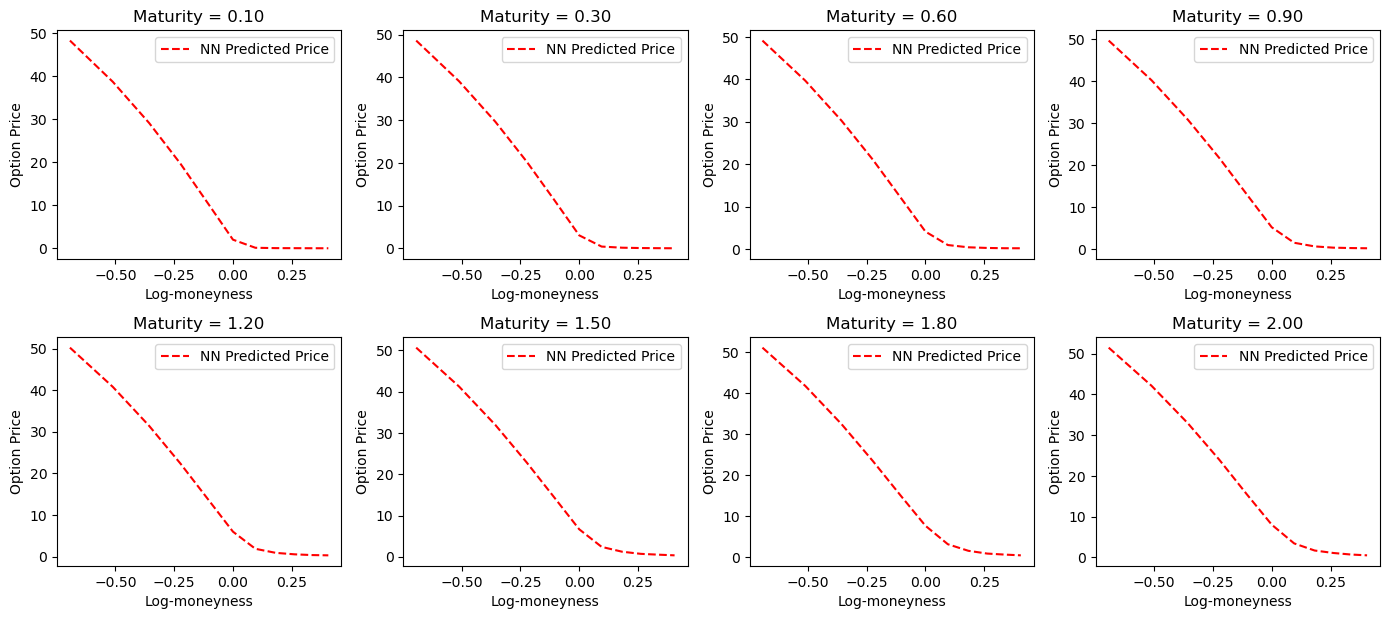

In [46]:
plt.figure(figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), y_pred_3[0, i * strikes_dim:(i + 1) * strikes_dim], 'r', linestyle="--", label="NN Predicted Price")

    plt.title(f"Maturity = {maturities[i]:.2f}")
    plt.xlabel("Log-moneyness")
    plt.ylabel("Option Price")
    plt.legend()

plt.tight_layout()
plt.show()

## Calibration to SPX volatility surface 5/12/2017

## Let's convert our CNN into Numpy

In [81]:
spx_surface = np.array(pd.read_csv('spx_surface.csv',header=None)).reshape(-1)

# References

1)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

2) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 2018